In [1]:
from PIL import Image
import os, glob, numpy as np
from sklearn.model_selection import train_test_split

caltech_dir = "project_fruit/train"
categories = ["tomato", "avocado", "strawberry", "zucchini"]
nb_classes = len(categories)

image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
y = []

for idx, cat in enumerate(categories):
    
    #one-hot 돌리기.
    label = [0 for i in range(nb_classes)]
    label[idx] = 1

    image_dir = caltech_dir + "/" + cat
    files = glob.glob(image_dir+"/*.jpg")
    print(cat, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)

        X.append(data)
        y.append(label)

        if i % 700 == 0:
            print(cat, " : ", f)

X = np.array(X)
y = np.array(y)
#1 0 0 0 이면 airplanes
#0 1 0 0 이면 buddha 이런식


X_train, X_test, y_train, y_test = train_test_split(X, y)
xy = (X_train, X_test, y_train, y_test)
np.save("multi_image_data.npy", xy)

print("ok", len(y))

tomato  파일 길이 :  1000
tomato  :  project_fruit/train/tomato\0.jpg
tomato  :  project_fruit/train/tomato\729.jpg
avocado  파일 길이 :  1169
avocado  :  project_fruit/train/avocado\0.jpg
avocado  :  project_fruit/train/avocado\577.jpg
strawberry  파일 길이 :  1002
strawberry  :  project_fruit/train/strawberry\0.jpg
strawberry  :  project_fruit/train/strawberry\727.jpg
zucchini  파일 길이 :  1009
zucchini  :  project_fruit/train/zucchini\0.jpg
zucchini  :  project_fruit/train/zucchini\720.jpg
ok 4180


C:\Users\gajig\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [2]:

import os, glob, numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session =  tf.compat.v1.Session(config=config)

X_train, X_test, y_train, y_test = np.load('multi_image_data.npy',allow_pickle=True)
print(X_train.shape)
print(X_train.shape[0])

(3135, 64, 64, 3)
3135


In [3]:
with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'],run_eagerly=True)
    model_dir = './model'
    
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    
    model_path = model_dir + '/multi_img_classification.model'
    checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6)

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0

In [5]:
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])

Epoch 1/50
98/98 [==============================] - ETA: 0s - loss: 44.4097 - accuracy: 0.3180
Epoch 1: val_loss improved from inf to 1.38138, saving model to ./model\multi_img_classification.model
INFO:tensorflow:Assets written to: ./model\multi_img_classification.model\assets
98/98 [==============================] - 20s 198ms/step - loss: 44.4097 - accuracy: 0.3180 - val_loss: 1.3814 - val_accuracy: 0.2660
Epoch 2/50
98/98 [==============================] - ETA: 0s - loss: 1.1997 - accuracy: 0.4431
Epoch 2: val_loss did not improve from 1.38138
98/98 [==============================] - 19s 192ms/step - loss: 1.1997 - accuracy: 0.4431 - val_loss: 1.3958 - val_accuracy: 0.2746
Epoch 3/50
98/98 [==============================] - ETA: 0s - loss: 1.0685 - accuracy: 0.4954
Epoch 3: val_loss improved from 1.38138 to 1.26356, saving model to ./model\multi_img_classification.model
INFO:tensorflow:Assets written to: ./model\multi_img_classification.model\assets
98/98 [==========================

Epoch 24/50
98/98 [==============================] - ETA: 0s - loss: 0.5076 - accuracy: 0.7809
Epoch 24: val_loss improved from 0.65802 to 0.64691, saving model to ./model\multi_img_classification.model
INFO:tensorflow:Assets written to: ./model\multi_img_classification.model\assets
98/98 [==============================] - 23s 239ms/step - loss: 0.5076 - accuracy: 0.7809 - val_loss: 0.6469 - val_accuracy: 0.7110
Epoch 25/50
98/98 [==============================] - ETA: 0s - loss: 0.5050 - accuracy: 0.7834
Epoch 25: val_loss improved from 0.64691 to 0.64235, saving model to ./model\multi_img_classification.model
INFO:tensorflow:Assets written to: ./model\multi_img_classification.model\assets
98/98 [==============================] - 20s 202ms/step - loss: 0.5050 - accuracy: 0.7834 - val_loss: 0.6424 - val_accuracy: 0.7081
Epoch 26/50
98/98 [==============================] - ETA: 0s - loss: 0.5005 - accuracy: 0.7793
Epoch 26: val_loss improved from 0.64235 to 0.62911, saving model to ./mo

In [6]:
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

33/33 [==============================] - 2s 54ms/step - loss: 0.6452 - accuracy: 0.7943
정확도 : 0.7943


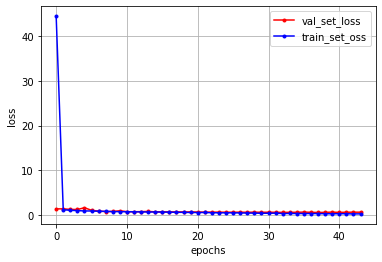

In [7]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

In [32]:
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model

caltech_dir = "project_fruit/test"
image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
filenames = []
files = glob.glob(caltech_dir+"/*.*")
for i, f in enumerate(files):
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    data = np.asarray(img)
    filenames.append(f)
    X.append(data)
    
    
X = np.array(X)
model = load_model('./model/multi_img_classification.model')

prediction = model.predict(X[:4])
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cnt = 0

#이 비교는 그냥 파일들이 있으면 해당 파일과 비교. 카테고리와 함께 비교해서 진행하는 것은 _4 파일.
for i in prediction:
    pre_ans = i.argmax()  # 예측 레이블
    print(i)
    print(pre_ans)
    pre_ans_str = ''
    if pre_ans == 0: pre_ans_str = "토마토"
    elif pre_ans == 1: pre_ans_str = "아보카도"
    elif pre_ans == 2: pre_ans_str = "딸기"
    else: pre_ans_str = "애호박"
    if i[0] >= 0.8 : print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[1] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"으로 추정됩니다.")
    if i[2] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[3] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    cnt += 1
    # print(i.argmax()) #얘가 레이블 [1. 0. 0.] 이런식으로 되어 있는 것을 숫자로 바꿔주는 것.
    # 즉 얘랑, 나중에 카테고리 데이터 불러와서 카테고리랑 비교를 해서 같으면 맞는거고, 아니면 틀린거로 취급하면 된다.

[0.000 0.964 0.000 0.035]
1
해당 0.jpg이미지는 아보카도으로 추정됩니다.
[0.001 0.000 0.000 0.999]
3
해당 1.jpg이미지는 애호박로 추정됩니다.
[0.997 0.000 0.003 0.000]
0
해당 100.jpg이미지는 토마토로 추정됩니다.
[0.000 0.025 0.000 0.974]
3
해당 110.jpg이미지는 애호박로 추정됩니다.
